# ARMA Models
Veremos temas sobre la estacionariedad y cómo esto es importante para los modelos ARMA. Aprenderá a probar la estacionariedad visualmente y con una prueba estadística estándar. Finalmente, aprenderá la estructura básica de los modelos ARMA y la usará para generar algunos datos ARMA y ajustar un modelo ARMA.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

## Introducción a las series temporales y la estacionariedad


### Exploration
En este ejercicio,trabajaremos sobre  un conjunto de datos de la producción mensual de dulces de EE. UU. Entre 1972 y 2018.

Específicamente, está trazando el índice de producción industrial IPG3113N. Esta es la cantidad total de productos de azúcar y confitería producidos en los EE. UU. Por mes, como porcentaje de la producción de enero de 2012. Entonces 120 sería el 120% de la producción industrial de enero de 2012.

Vea cómo esta cantidad ha cambiado con el tiempo y cómo cambia a lo largo del año.

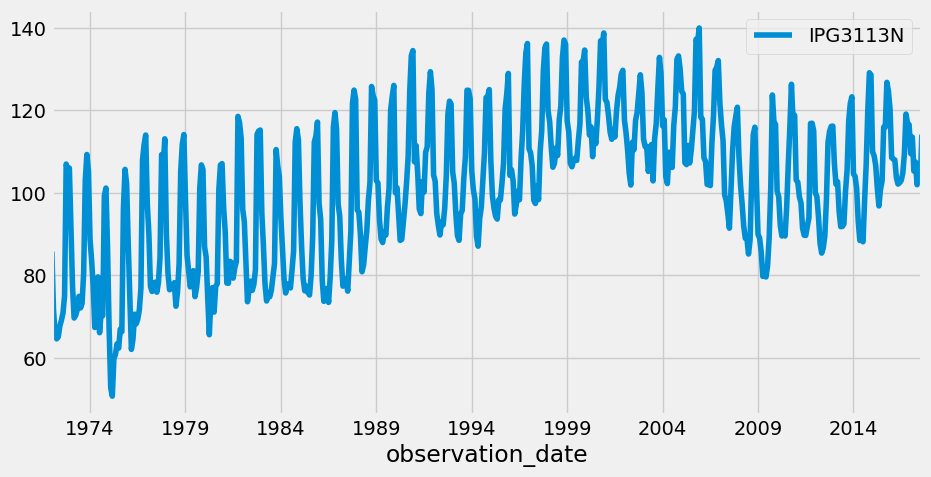

In [2]:
# Load in the time series
candy = pd.read_csv('candy_production.csv', index_col='observation_date', parse_dates=True)
# Plot ant show the time series on axis ax
fig, ax = plt.subplots();
candy.plot(ax=ax);

### train-test data
En este ejercicio, tomará el conjunto de datos de producción de dulces y lo dividirá en un train y test data. La razón para hacer esto es para que pueda probar la calidad del ajuste de su modelo cuando haya terminado.

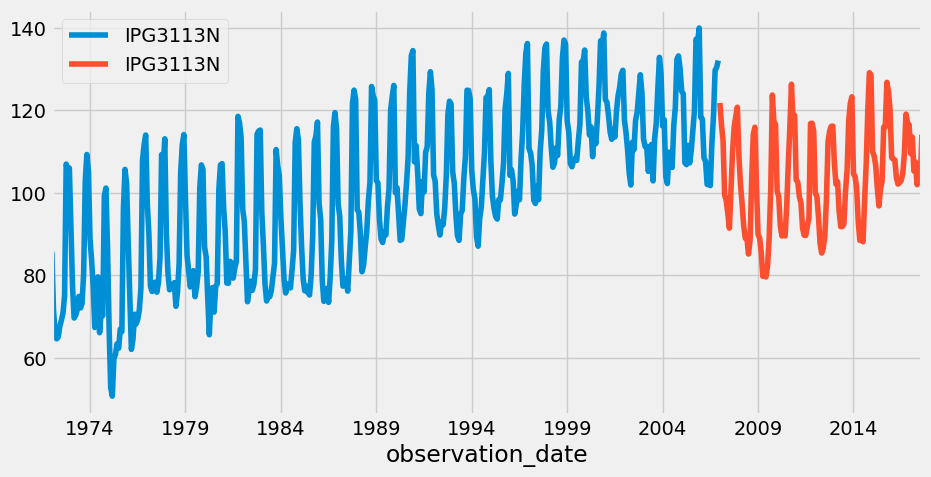

In [3]:
# Split the data into a train and test set
candy_train = candy.loc[:'2006']
candy_test = candy.loc['2007':]

# Create an axis
fig, ax = plt.subplots();

# Plot the train and test sets on the axis ax
candy_train.plot(ax=ax);
candy_test.plot(ax=ax);
#plt.savefig('../train_test.png')

### ¿Es estacionario?
Es muy importante identificar si una serie de tiempo es estacionaria o no estacionaria. Si está estacionario, puede usar modelos ARMA para predecir los siguientes valores de la serie temporal. Si no es estacionario, entonces no puede usar modelos ARMA; sin embargo, a menudo puede transformar series de tiempo no estacionarias en estacionarias.


## Hacer estacionarias las series de tiempo
- La prueba aumentada de Dicky-Fuller
    - Pruebas para no estacionario
    - La hipótesis nula es que la serie de tiempo no es estacionaria

### Dicky-Fuller aumentado
Ejecutaremos la prueba Dicky-Fuller aumentada en la serie temporal de produccion de caramelos para probar la estacionariedad. Graficamos esta serie de tiempo en el último ejercicio. Parecía que podría estar estacionario, si queremos hacer predicciones sobre la produccion con un modelo arma hay que estar seguros de ello.




In [4]:
candy

,IPG3113N
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100
...,...
2017-04-01,107.4288
2017-05-01,101.9209
2017-06-01,104.2022


In [5]:
from statsmodels.tsa.stattools import adfuller

# Run test
result = adfuller(candy['IPG3113N'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])
#0.333>0.05,
# Print critical values
print(result[4]) 

-1.887049811225274
0.3381775973004322
{'1%': -3.442678467240966, '5%': -2.8669778698997543, '10%': -2.5696661916864083}


### Tomando la diferencia
Preparaemos una serie de tiempo de la población del mundo para modelarla. Si pudiera predecir la tasa de crecimiento del mundo, entonces sería posible planificar y construir la infraestructura que el mundo necesitará más adelante, con lo que el gasto público estará preparado para el futuro. En este caso, la serie temporal es del banco mundial

Probaremos la estacionariedad visualmente y usará la prueba Augmented Dicky-Fuller, y tomaremos la diferencia para hacer que el conjunto de datos sea estacionario.

In [6]:
city = pd.read_csv('./population.csv',sep=';', parse_dates=True, index_col='year')

In [7]:
city.columns

Index(['Population'], dtype='object')

ADF Statistic: -0.5569529454860563
p-value: 0.880415295622619


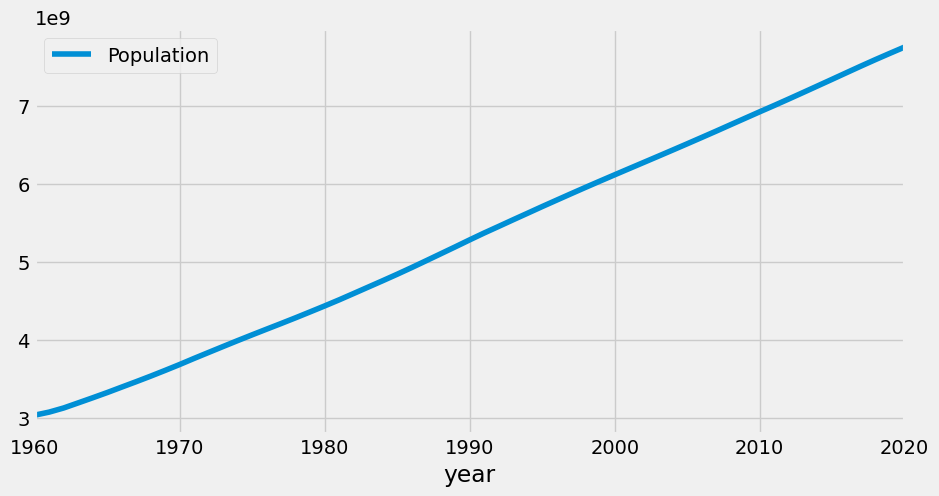

In [8]:
# Run the ADF test on the time series
result = adfuller(city['Population'])

# Plot the time series
fig, ax = plt.subplots();
city.plot(ax=ax);

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.6856680589005686
p-value: 0.07655132512000053


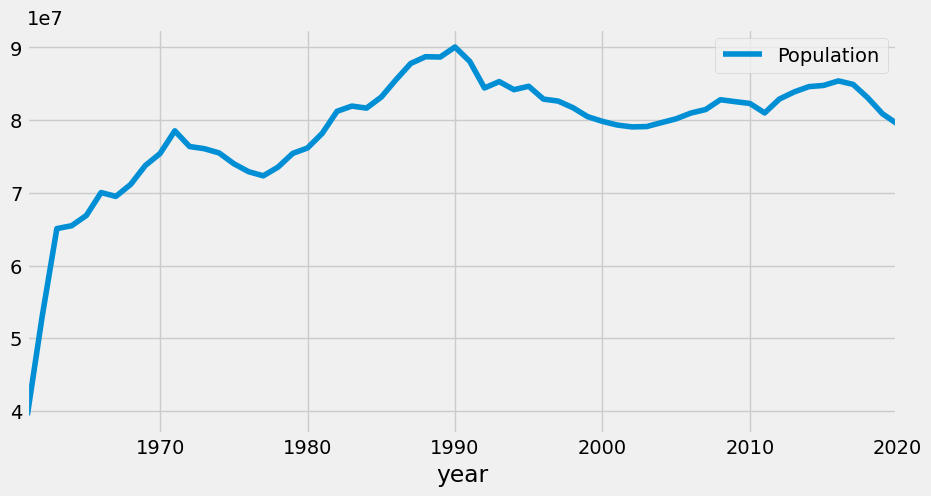

In [9]:
# Calculate the first difference of the time series
city_stationary = city.diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(city_stationary['Population'])

# Plot the differenced time series
fig, ax = plt.subplots();
city_stationary.plot(ax=ax);

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -6.335620510375783
p-value: 2.8355147477168158e-08


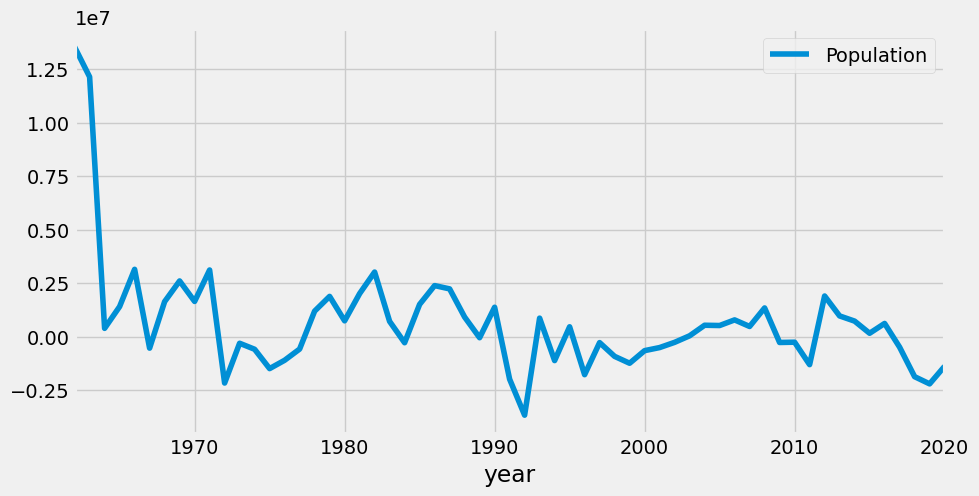

In [10]:
# Calculate the second difference of the time series
city_stationary = city.diff().diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(city_stationary['Population'])

# Plot the differenced time series
fig, ax = plt.subplots();
city_stationary.plot(ax=ax);

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

### Otras transformaciones
La diferenciación debe ser la primera transformación que intente hacer estacionaria una serie de tiempo. Pero a veces no es la mejor opción.

Una forma clásica de transformar series de tiempo de valores es el retorno logarítmico de la serie. Esto se calcula de la siguiente manera:
$$ \log\text{_return} (y_t) = \log \big(\frac{y_t}{y_{t-1}}\big)$$


Puede calcular el retorno de registro de este DataFrame sustituyendo:

$y_t$ → amazon

$y_{t-1}$ → amazon.shift(1)

$\log()$ → ```np.log()```

Comparemos la transformación de retorno de registro y la diferencia de primer orden de la serie temporal de acciones de Amazon para encontrar cuál es mejor para hacer que la serie temporal sea estacionaria.

In [11]:
# Date range
start = '2016-01-01'
end = '2021-06-30'

# Tickers of assets
assets = ['AMZN']


# Downloading data
amazon= yf.download(assets, start = start, end = end)['Close']
amazon.head()

[*********************100%***********************]  1 of 1 completed


Date
2016-01-04    31.849501
2016-01-05    31.689501
2016-01-06    31.632500
2016-01-07    30.396999
2016-01-08    30.352501
Name: Close, dtype: float64

In [12]:
# Calculate the first difference and drop the nans
amazon_diff = amazon.diff()
amazon_diff = amazon_diff.dropna()

# Run test and print
result_diff = adfuller(amazon_diff)
print(result_diff)

(-8.911114710341463, 1.103665397965318e-14, 24, 1356, {'1%': -3.435181653580997, '5%': -2.8636738084031768, '10%': -2.5679060409542207}, 5503.256616117984)


In [13]:
# Calculate the log-return and drop nans
amazon_log = np.log(amazon.div(amazon.shift(1)))
amazon_log = amazon_log.dropna()

# Run test and print
result_log = adfuller(amazon_log)
print(result_log)

(-14.704195249599385, 2.9147374416003214e-27, 7, 1373, {'1%': -3.4351217173485766, '5%': -2.8636473597946974, '10%': -2.567891956216259}, -7016.967473774115)


## Intro a modelos AR, MA and ARMA 
- AR models
    - Autoregressive (AR) model
        - AR(1) model:
$$ y_t = a_1 y_{t-1} + \epsilon_t $$
        - AR(2) model:
$$ y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t $$
        - AR(p) model:
$$ y_t = a_1 y_{t-1} + a_2 y_{t-2} + \cdots + a_p y_{t-p} + \epsilon_t $$
- MA models
    - Moving Average (MA) model
        - MA(1) model:
$$ y_t = m_1 \epsilon_{t-1} + \epsilon_t $$
        - MA(2) model:
$$ y_t = m_1 \epsilon_{t-1} + m_2 \epsilon_{t-2} + \epsilon_t $$
        - MA(q) model:
$$ y_t = m_1 \epsilon_{t-1} + m_2 \epsilon_{t-2} + \cdots + m_q \epsilon_{t-q} + \epsilon_t $$ 
- ARMA models
    - Autoregressive moving-average (ARMA) model
    - ARMA = AR + MA
        - ARMA(1, 1) model:
$$ y_t = a_1 y_{t-1} + m_1 \epsilon_{t-1} + \epsilon_t $$
        - ARMA(p, q) model:
            - p is order of AR part
            - q is order of MA part

### Model order
Al ajustar y trabajar con modelos AR, MA y ARMA, es muy importante comprender el orden de los modelos. Deberá elegir el orden del modelo al instalarlo. Elegir esto correctamente le dará un modelo de mejor ajuste que hace mejores predicciones. 

In [14]:
ar_coefs = [1, 0.8, -0.1] # constantes, ar1, ar2
ma_coefs = [1, 0.2] #constante, ma1

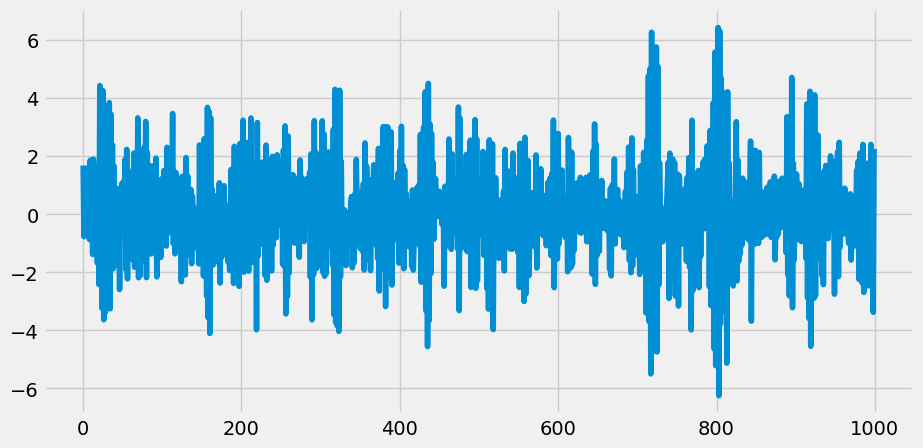

In [15]:
from statsmodels.tsa.arima_process import arma_generate_sample

y = arma_generate_sample(ar_coefs, ma_coefs, nsample=1000)

plt.plot(y);

### Generating ARMA data
En este ejercicio, generará 100 días de datos AR / MA / ARMA. Recuerde que en las aplicaciones del mundo real, estos datos podrían ser cambios en los precios de las acciones de Google, los requisitos energéticos de la ciudad de Nueva York o el número de casos de gripe.


Puedes usar el ```arma_generate_sample()``` función disponible en su espacio de trabajo para generar series de tiempo usando diferentes coeficientes AR y MA.


Recuerde para cualquier modelo ARMA (p, q):

- La lista ar_coefs tiene la forma$[1, -a_1, -a_2, ..., -a_p]$.
- La lista ma_coefs tiene la forma $[1, m_1, m_2, ..., m_q]$,

Donde $a_i$ son los coeficientes de retardo-i AR y $ m_j $ son los coeficientes de retardo-j MA.

In [16]:
np.random.seed(1)

#### MA(1) model with MA lag coefficient of -0.7

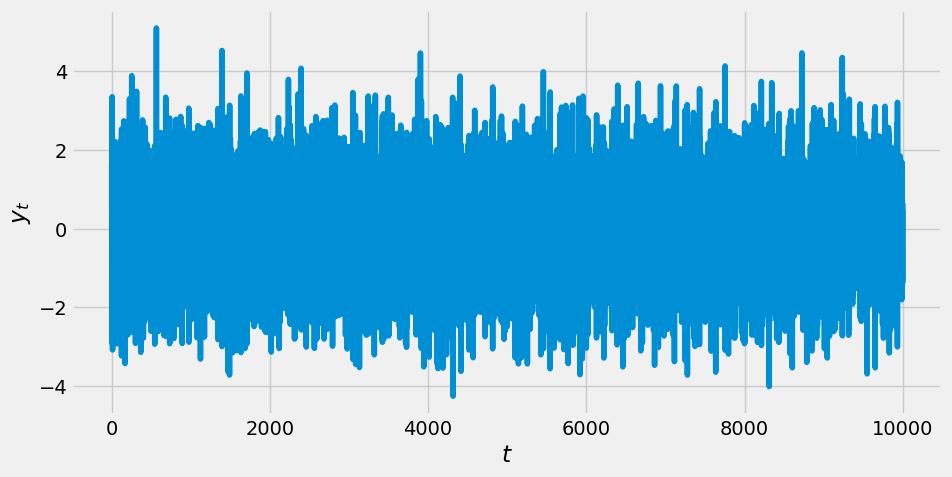

In [17]:
# Set coefficients
ar_coefs = [1]
ma_coefs = [1, -0.7]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=10000)

plt.plot(y);
plt.ylabel(r'$y_t$');
plt.xlabel(r'$t$');

D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


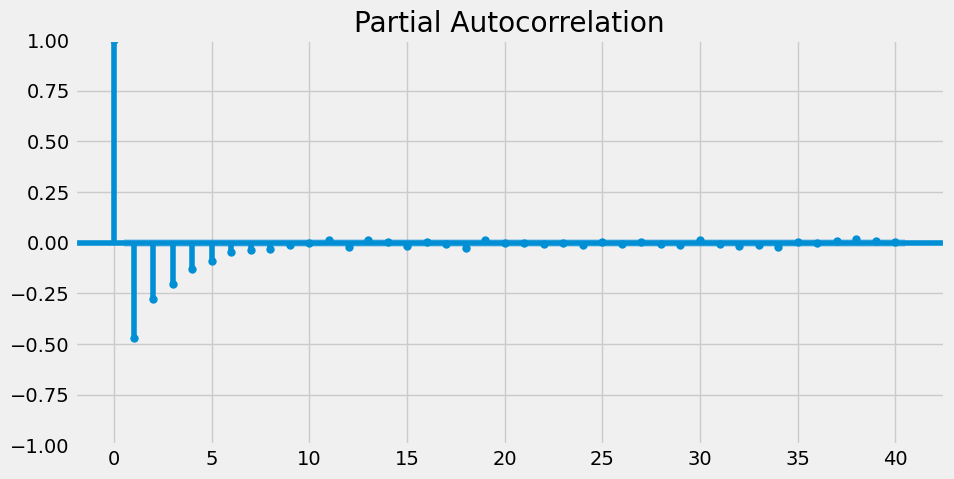

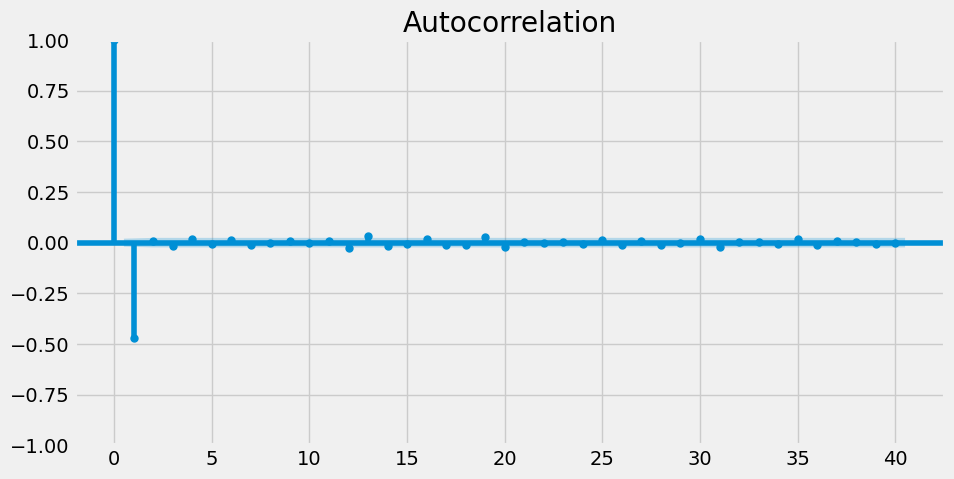

In [18]:
plot_pacf(y);
plot_acf(y);

#### AR(2) model with AR lag-1 and lag-2 coefficients of 0.3 and 0.2

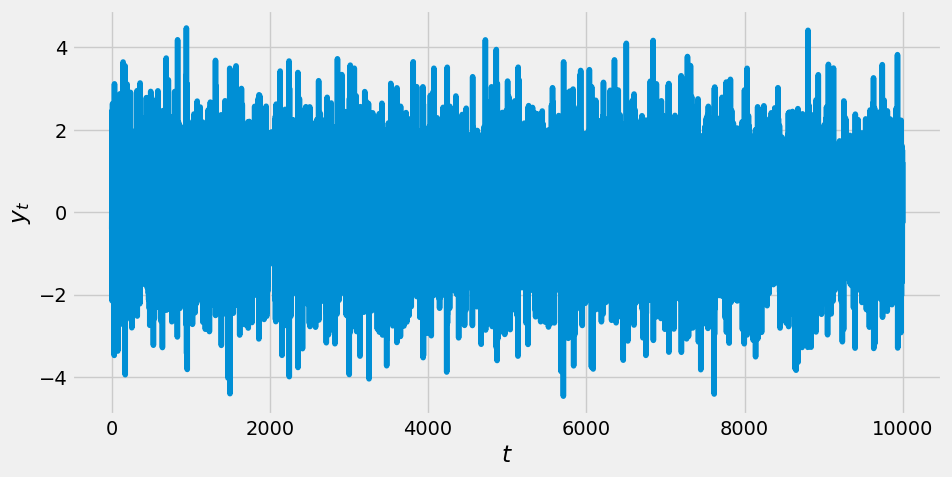

In [19]:
np.random.seed(2)

# Set coefficients
ar_coefs = [1, 0.3, 0.2,0.5]
ma_coefs = [1]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=10000)

plt.plot(y);
plt.ylabel(r'$y_t$');
plt.xlabel(r'$t$');

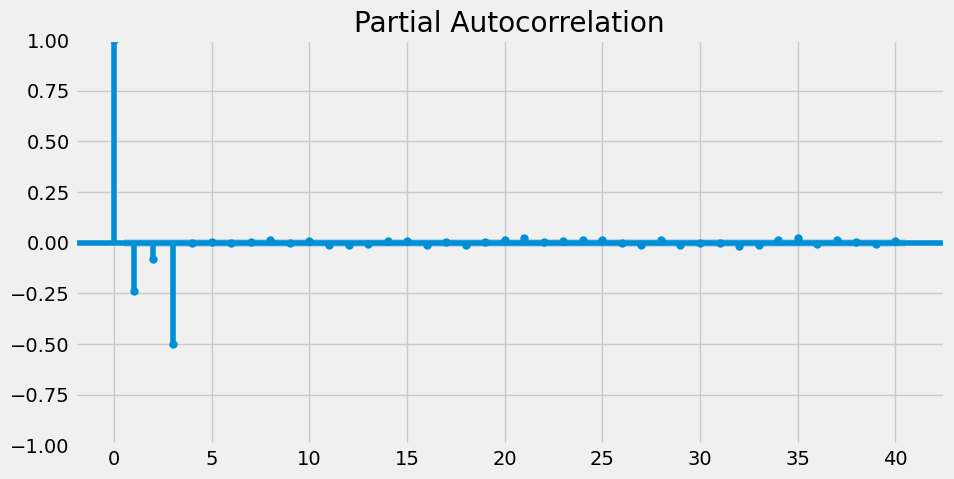

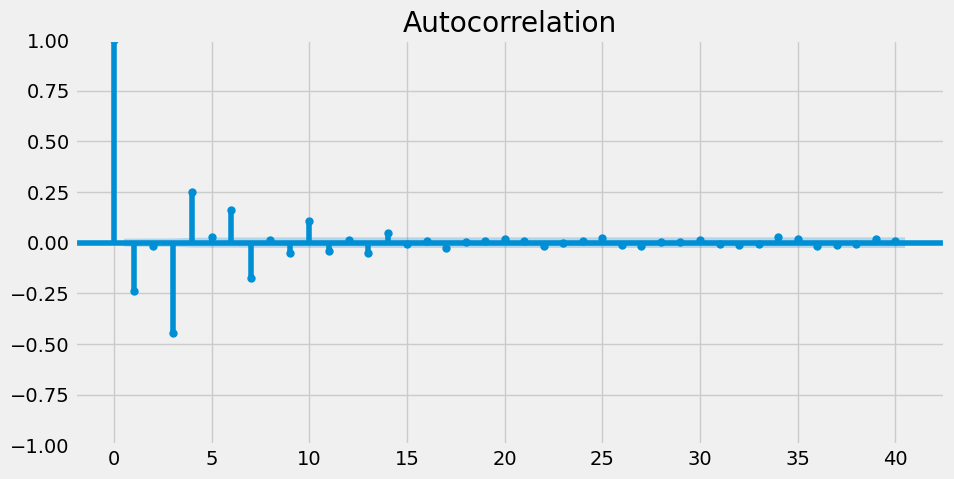

In [20]:
plot_pacf(y);
plot_acf(y);

#### ARMA model with $y_t = -0.2 y_{t-1} + 0.3 \epsilon_{t-1} + 0.4 \epsilon_{t-2} + \epsilon_t$

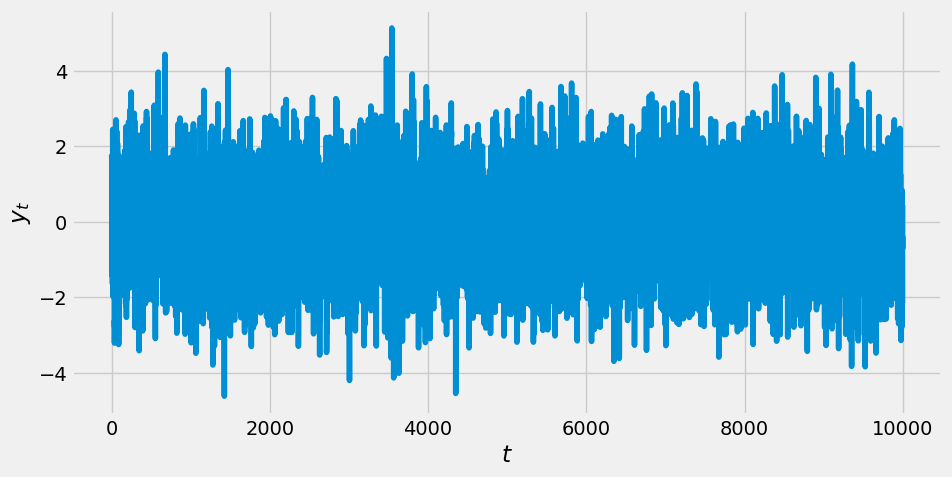

In [21]:
np.random.seed(3)

# Set coefficients
ar_coefs = [1, -0.2]
ma_coefs = [1, 0.3, 0.4]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=10000)

plt.plot(y);
plt.ylabel(r'$y_t$');
plt.xlabel(r'$t$');

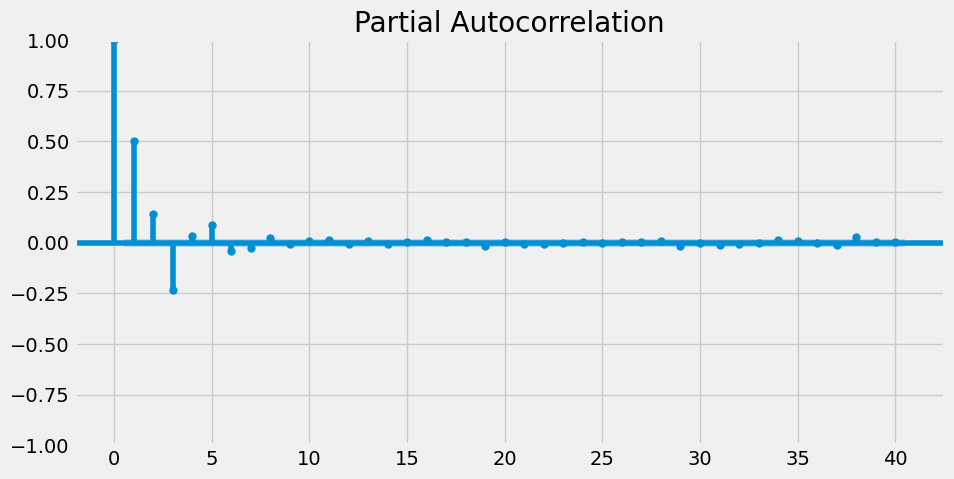

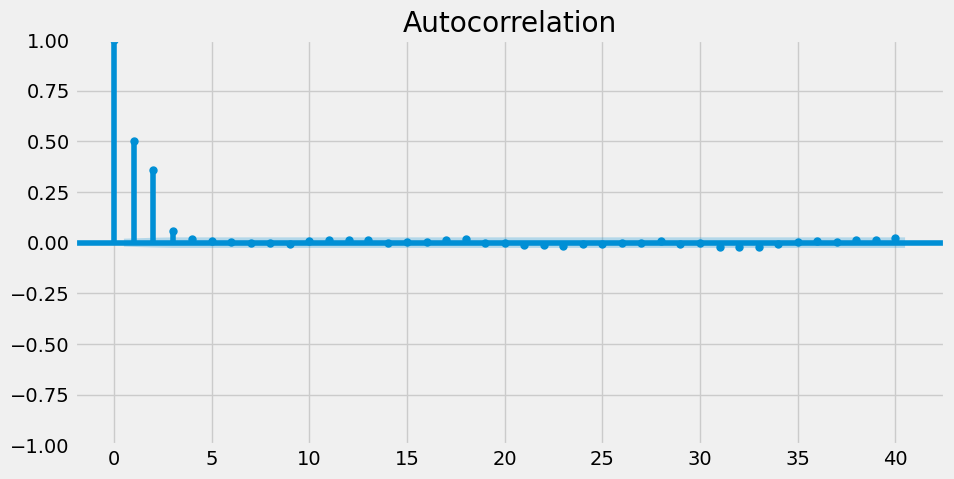

In [22]:
plot_pacf(y);
plot_acf(y);

### Modelo ARIMA
ARIMA son las siglas de AutoRegressive Integrated Moving Average.
Este modelo es la combinación de autorregresión, un modelo de media móvil y diferenciación. En este contexto, la integración es lo opuesto a la diferenciación.
La diferenciación es útil para eliminar la tendencia en una serie de tiempo y hacerla estacionaria.
Simplemente implica restar un punto a t-1 del tiempo t. Tenga en cuenta que, por lo tanto, perderá el primer punto de datos de una serie de tiempo si aplica la diferenciación una vez.
Matemáticamente, ARIMA (p, d, q) ahora requiere tres parámetros:
p: el orden del proceso autorregresivo
d: el grado de diferenciación (número de veces que se diferencia)
q: el orden del proceso de media móvil
y las ecuaciones se expresan como:
<figure>
<center>
<img src='https://miro.medium.com/max/700/1*j-ttTMDiaIXIuBzrhP0MaA.png' />
</center>
</figure>


Al igual que con los modelos ARMA, ACF y PACF no se pueden usar para identificar valores confiables para py q.
Sin embargo, en presencia de un proceso ARIMA (p, d, 0):
* El ACF está decayendo exponencialmente o sinusoidal
* El PACF tiene un aumento significativo en el rezago p pero ninguno después

Del mismo modo, en presencia de un proceso ARIMA (0, d, q):
* El PACF está decayendo exponencialmente o sinusoidal
* El ACF tiene un pico significativo en el rezago q pero ninguno después

Analicemos un ejemplo de modelado con ARIMA para obtener experiencia práctica y comprender mejor algunos conceptos de modelado.

## modelado el precio diario de Johnson & Johnson

modelaremos la serie de tiempo con un modelo ARIMA (p, d, q).

In [23]:
# Date range
start = '2018-01-01'
end = '2021-06-30'

# Tickers of assets
assets = ['JNJ']


# Downloading data
data= yf.download(assets, start = start, end = end)['Close']
data.head()

[*********************100%***********************]  1 of 1 completed


Date
2018-01-02    139.229996
2018-01-03    140.559998
2018-01-04    140.550003
2018-01-05    141.710007
2018-01-08    141.889999
Name: Close, dtype: float64

In [24]:
data=data.reset_index()

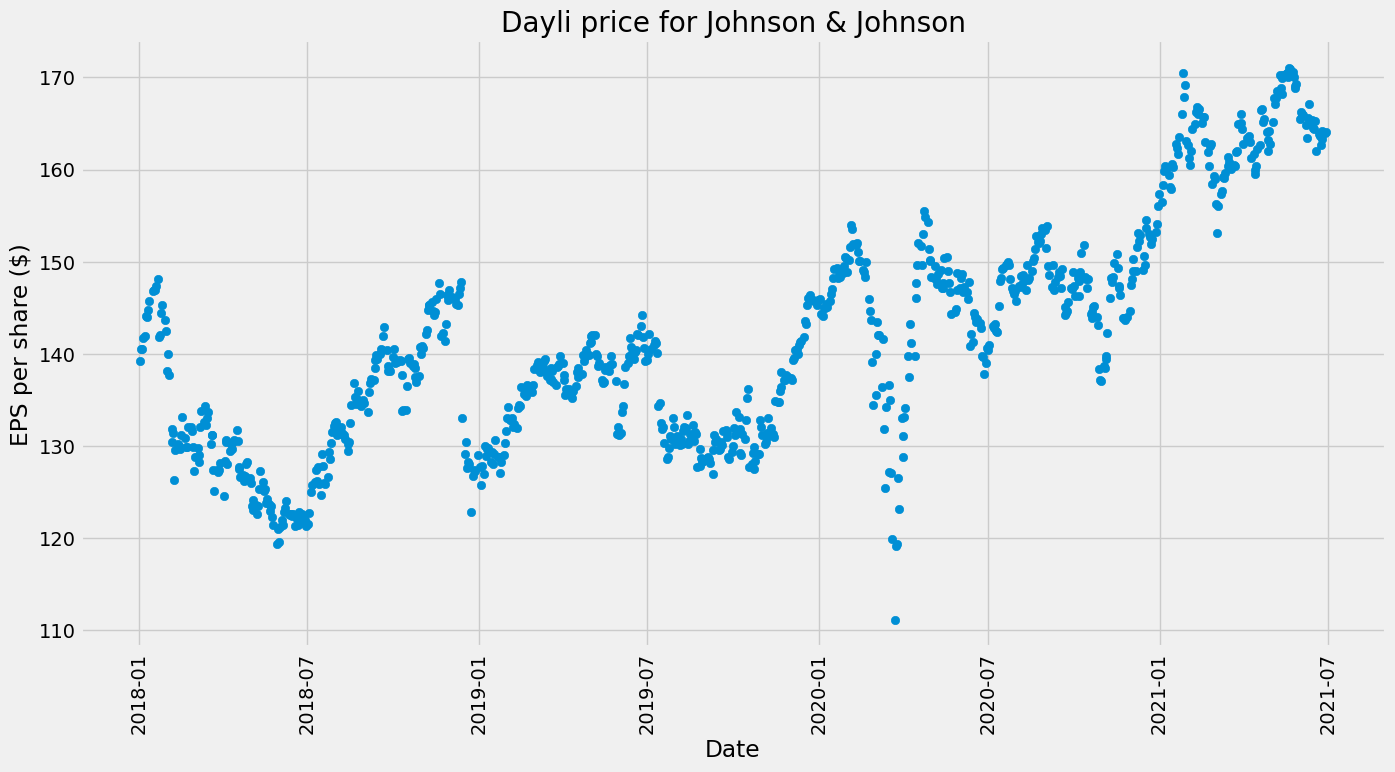

In [25]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(data['Date'], data['Close'])
plt.title('Dayli price for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


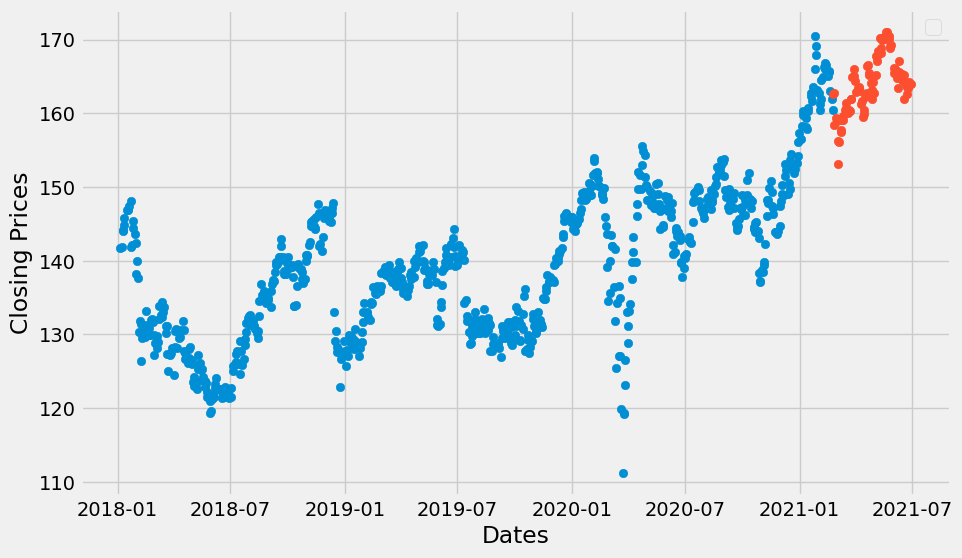

In [26]:
#split data into train and training set
train_data, test_data = data[3:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.scatter(train_data['Date'], train_data['Close'])
plt.scatter(test_data['Date'], test_data['Close'])
plt.legend()

Se puede observar que tiene una tendencia y la varianza cambia en el tiempo.

Grafiquemos el ACF y el PACF

D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


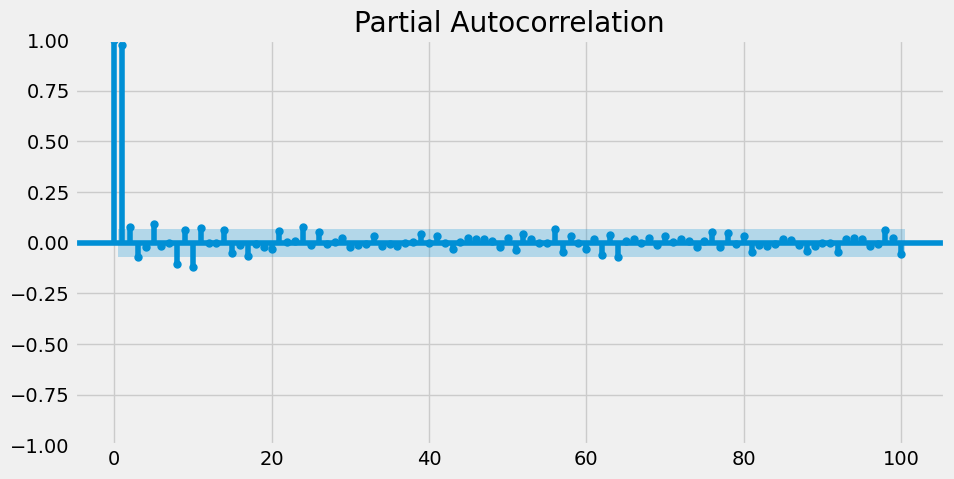

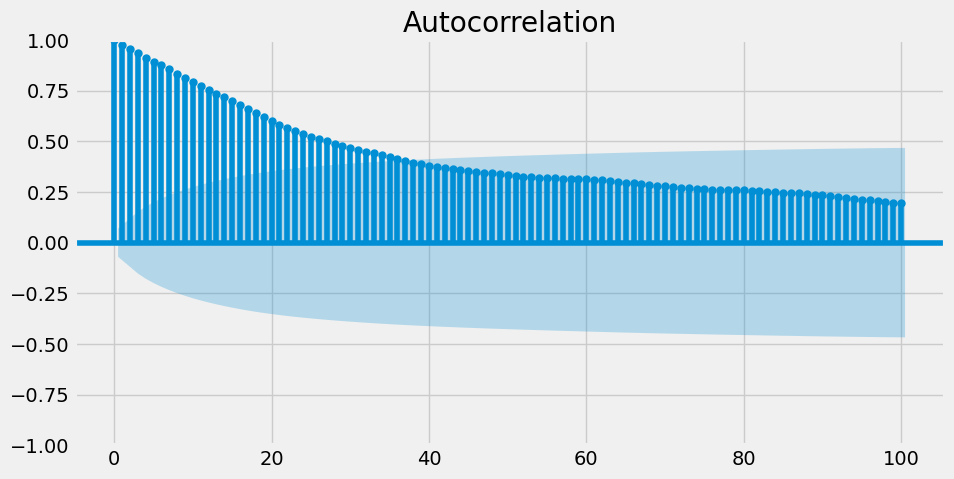

In [27]:
plot_pacf(train_data['Close'],lags=100);
plot_acf(train_data['Close'],lags=100);

Como se puede ver no hay forma de determinar el orden correcto del proceso AR(P) o MA(q).

Los graficos nos indican que no hay estacionariedad.Aplicaremos por lo tanto Dickey Fuller Test.

In [28]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(train_data['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.187663122434266
p-value: 0.21075346209311685


Un P value mayor que 0.05 indica que no podemos rechazar la hipotesis nula que la serie no es estacionaria. por lo tanto debemos aplicar una transformacion y alguna diferenciacion para remover la tendencia y remover la varianza cambiante en el tiempo.

In [29]:
# Take the log difference to make data stationary
train_data['lClose'] = np.log(train_data['Close'])
train_data['lClose'] = train_data['lClose'].diff()
train_data_f = train_data.drop(train_data.index[0])
train_data_f.head()

C:\Users\LUIGGI\AppData\Local\Temp\ipykernel_4668\1056321437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['lClose'] = np.log(train_data['Close'])
C:\Users\LUIGGI\AppData\Local\Temp\ipykernel_4668\1056321437.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['lClose'] = train_data['lClose'].diff()


,Date,Close,lClose
4,2018-01-08,141.889999,0.001269
5,2018-01-09,144.139999,0.015733
6,2018-01-10,143.970001,-0.001180
7,2018-01-11,144.789993,0.005679
8,2018-01-12,145.759995,0.006677


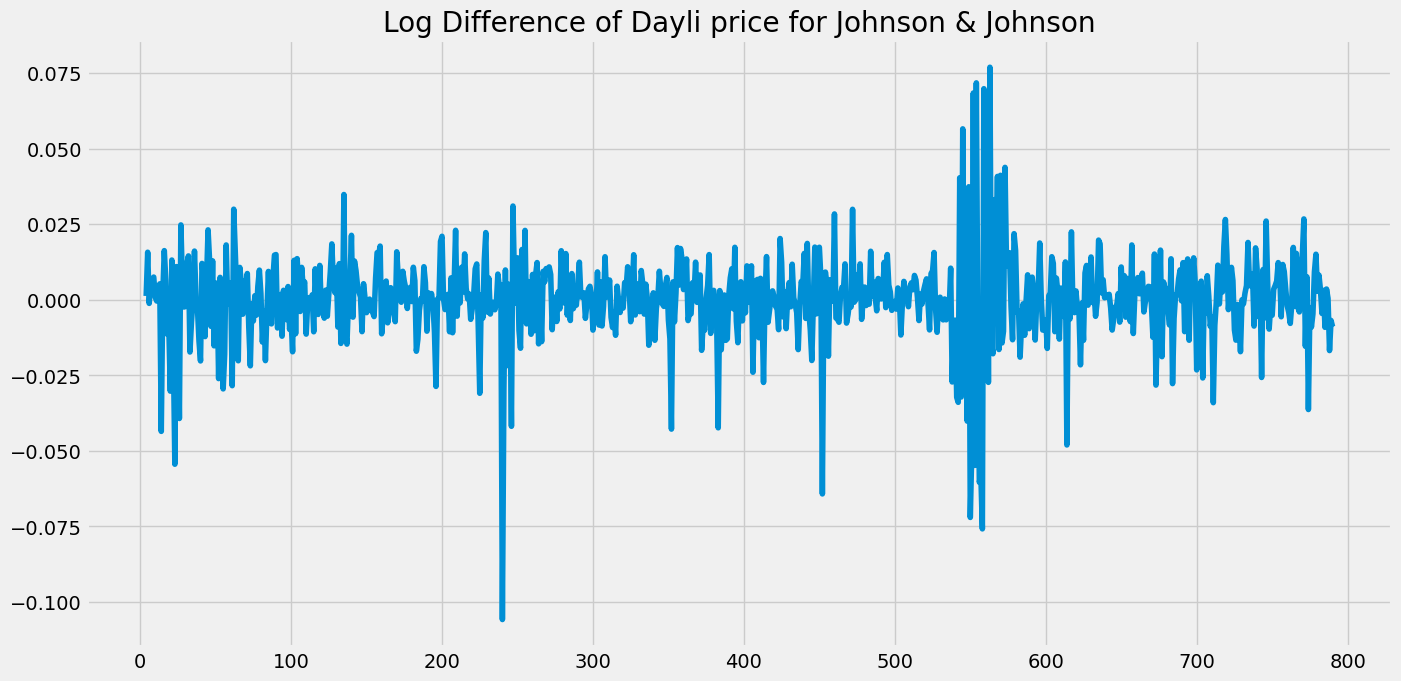

In [30]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(train_data_f['lClose'])
plt.title("Log Difference of Dayli price for Johnson & Johnson")
plt.show()

Parece que la tendencia y el cambio en la varianza se eliminaron, pero queremos asegurarnos de que sea así. Por lo tanto, aplicamos nuevamente la prueba aumentada de Dickey-Fuller para probar la estacionariedad.

In [31]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(train_data_f['lClose'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -8.987695475919661
p-value: 7.027952212574087e-15


Esta vez, el valor p es menor que 0.05, rechazamos la hipótesis nula y asumimos que la serie de tiempo es estacionaria.
Ahora, observemos el PACF y el ACF para ver si podemos estimar el orden de uno de los procesos en juego.

D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


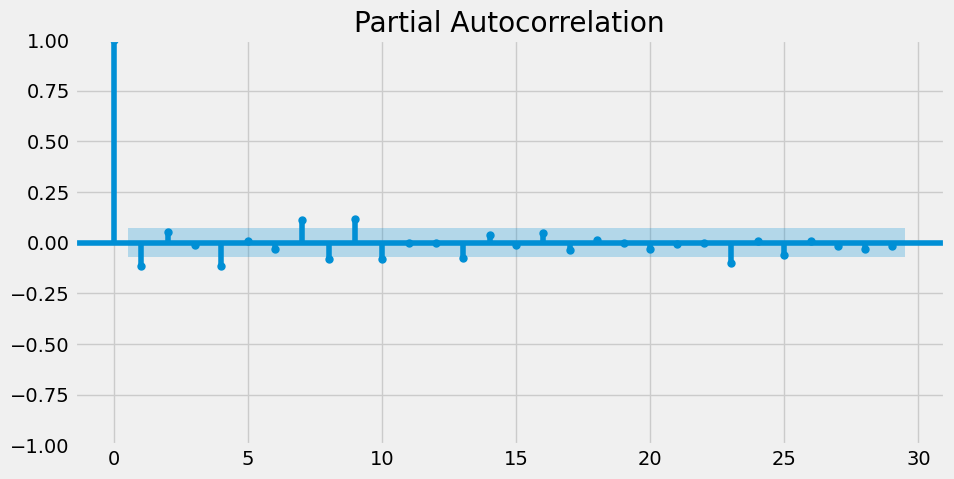

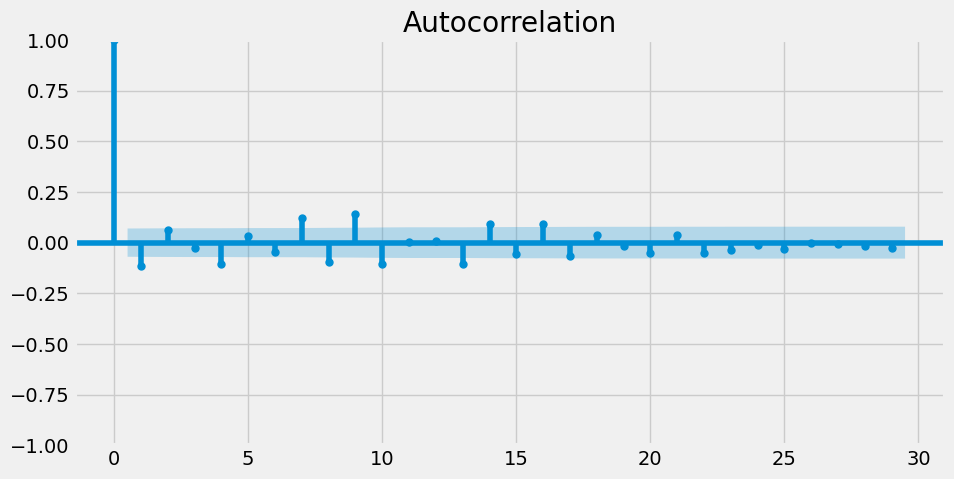

In [32]:
plot_pacf(train_data_f['lClose']);
plot_acf(train_data_f['lClose']);

Examinando el PACF anterior, parece que hay un proceso ar de orden 3 o 4 en juego o un ma de orden 7. Sin embargo, el ACF no es informativo y vemos alguna forma sinusoidal.
Por lo tanto, ¿cómo podemos asegurarnos de que elegimos el orden correcto para los procesos AR (p) y MA (q)?
Necesitaremos probar diferentes combinaciones de órdenes, ajustar un modelo ARIMA con esas órdenes y usar un criterio para la selección de órdenes.
Esto nos lleva al tema del Criterio de información de Akaike o AIC.

##Criterio de información de Akaike (AIC)
Este criterio es útil para seleccionar el orden (p,d,q) de un modelo ARIMA. El AIC se expresa como:
<figure>
<center>
<img src='https://miro.medium.com/max/1206/1*n4MGyp9Mrhw0unW5oplH2w.png' />
</center>
</figure>

Donde L es la probabilidad de los datos y k es el número de parámetros.
En la práctica, seleccionamos el modelo con el AIC más bajo en comparación con otros modelos.

Es importante tener en cuenta que el AIC no se puede utilizar para seleccionar el orden de diferenciación (d). La diferenciación de los datos cambiará la probabilidad (L) de los datos. Por lo tanto, el AIC de los modelos con diferentes órdenes de diferenciación no es comparable.

Ahora que sabemos cómo basaremos nuestra decisión de seleccionar el mejor orden para el modelo ARIMA, escribamos una función que probará todos los pedidos para nosotros.

In [33]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

La función anterior dará como resultado una trama de datos que enumerará las órdenes y el AIC correspondiente, comenzando con el mejor modelo en la parte superior.
Intentaremos todas las combinaciones con órdenes (p,q) que van de 0 a 8, pero manteniendo el orden de diferenciación igual a 1.

In [34]:
parameters_list

NameError: name 'parameters_list' is not defined

In [35]:
from itertools import product
ps = range(0, 8, 1)
d = 2
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
#result_df = optimize_ARIMA(order_list, exog=train_data['Close'])
#result_df
order_list

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 2, 7),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 2, 5),
 (2, 2, 6),
 (2, 2, 7),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (3, 2, 5),
 (3, 2, 6),
 (3, 2, 7),
 (4, 2, 0),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4),
 (4, 2, 5),
 (4, 2, 6),
 (4, 2, 7),
 (5, 2, 0),
 (5, 2, 1),
 (5, 2, 2),
 (5, 2, 3),
 (5, 2, 4),
 (5, 2, 5),
 (5, 2, 6),
 (5, 2, 7),
 (6, 2, 0),
 (6, 2, 1),
 (6, 2, 2),
 (6, 2, 3),
 (6, 2, 4),
 (6, 2, 5),
 (6, 2, 6),
 (6, 2, 7),
 (7, 2, 0),
 (7, 2, 1),
 (7, 2, 2),
 (7, 2, 3),
 (7, 2, 4),
 (7, 2, 5),
 (7, 2, 6),
 (7, 2, 7)]

Una vez que la función haya terminado de ejecutarse, debería ver que el orden asociado con el AIC más bajo es (7,1,2). Por lo tanto, esto sugiere que son el modelo ARIMA con un proceso AR(7) y un proceso MA(2).
Ahora, podemos imprimir un resumen del mejor modelo, que un ARIMA (7,1,2).

In [36]:
best_model = SARIMAX(data['Close'], order=(7,1,2)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  879
Model:               SARIMAX(7, 1, 2)   Log Likelihood               -1807.655
Date:                Wed, 09 Nov 2022   AIC                           3635.311
Time:                        23:59:31   BIC                           3683.087
Sample:                             0   HQIC                          3653.583
                                - 879                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5722      0.079    -19.849      0.000      -1.727      -1.417
ar.L2         -0.8401      0.079    -10.573      0.000      -0.996      -0.684
ar.L3         -0.0063      0.043     -0.147      0.8

En el resumen anterior, podemos ver el valor de todos los coeficientes y sus valores p asociados. Observe cómo el parámetro para el proceso ar en el retraso 3,4,6,7 no parece ser estadísticamente significativo de acuerdo con el valor p. Aún así, vamos a mantenerlo en el modelo por ahora.

Donde épsilon es ruido con una varianza de 3,5941.

La parte final del modelado de una serie temporal es estudiar los residuos.
Idealmente, los residuos serán ruido blanco, sin autocorrelación
Una buena manera de probar esto es usar la prueba de Ljung-Box. Tenga en cuenta que esta prueba solo se puede aplicar a los residuos.


In [37]:
# Ljung-Box test
ljung_box, p_value = acorr_ljungbox(best_model.resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: lb_stat
p-value: lb_pvalue


Aquí, la hipótesis nula para la prueba de Ljung-Box es que no hay autocorrelación. Mirando los valores p anteriores, podemos ver que están por encima de 0.05. Por lo tanto, no podemos rechazar la hipótesis nula, y los residuos no están correlacionados.

Podemos apoyar aún más eso trazando el ACF y PACF de los residuos.


D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


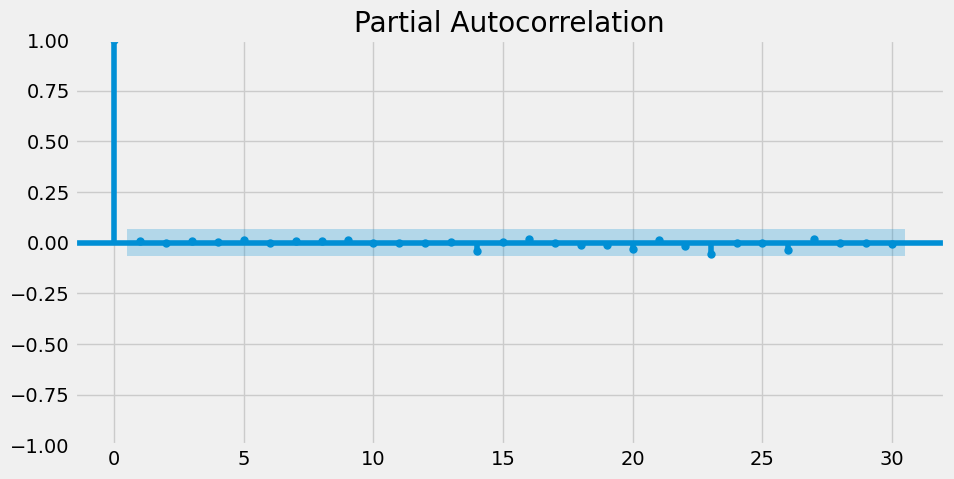

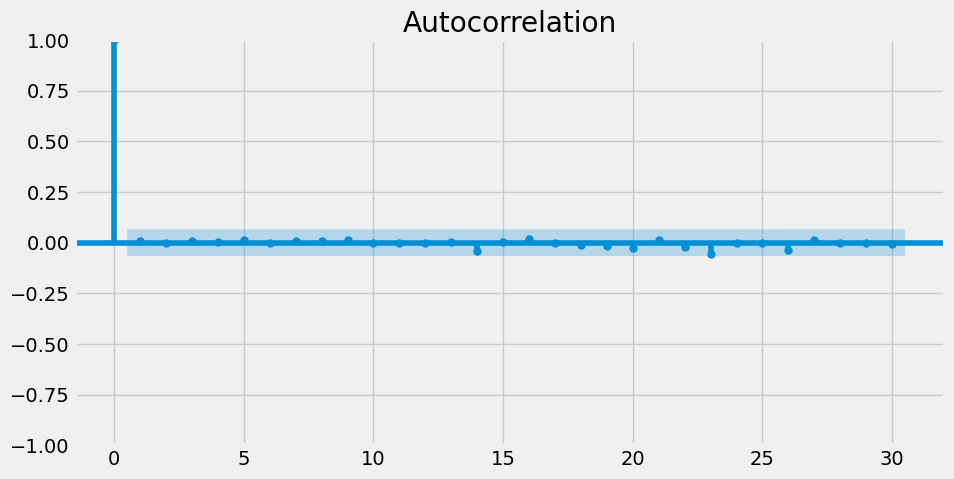

In [38]:
plot_pacf(best_model.resid);
plot_acf(best_model.resid);

Como puede ver, las parcelas anteriores se asemejan a las del ruido blanco.
Por lo tanto, este modelo está listo para usarse para la previsión.

#Procedimiento general de modelización
Este es un procedimiento general que puede seguir siempre que se enfrente a una serie temporal:

1) Trace los datos e identifique las observaciones no individuales. Comprender el patrón de los datos.

2)Aplicar una transormación o diferenciación para eliminar la tendencia y estabilizar la varianza

3) Prueba de estacionariedad. Si la serie no es estacionaria, aplique otra transformación o diferenciación.

4) Trazar el ACF y PACF para tal vez estimar el orden del proceso MA o AR.

5) Pruebe diferentes combinaciones de órdenes y seleccione el modelo con el AIC más bajo.

6) Compruebe los residuos y asegúrese de que se ven como ruido blanco. Aplique la prueba Ljung-Box para asegurarse.

7)Calcular previsiones/proyecciones

In [39]:
model = ARIMA(train_data['Close'], order=(7, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  788
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -1637.836
Date:                Wed, 09 Nov 2022   AIC                           3295.672
Time:                        23:59:33   BIC                           3342.354
Sample:                             0   HQIC                          3313.619
                                - 788                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5375      0.081    -18.977      0.000      -1.696      -1.379
ar.L2         -0.8139      0.084     -9.713      0.000      -0.978      -0.650
ar.L3         -0.0005      0.045     -0.011      0.9

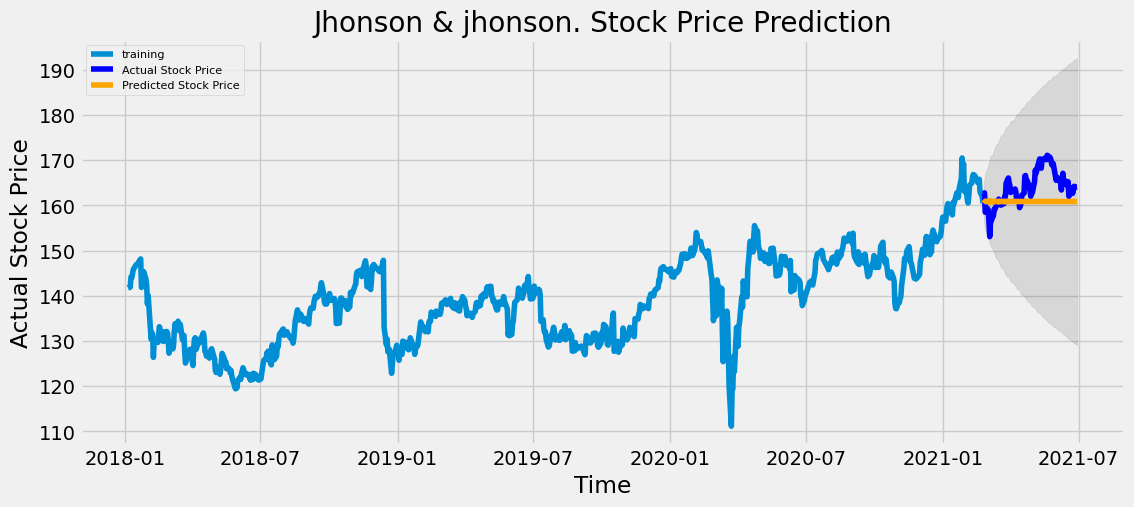

In [81]:
# Forecast
fc = fitted.get_forecast(88)  # 95% confidence
conf = fc.conf_int(alpha=0.05)
y_hat = fc.predicted_mean
#conf = fitted.conf_int(alpha=0.05)
fc_series = pd.Series(y_hat.values, index=test_data['Date'])
fc_series=fc_series.reset_index()
fc_series.columns=['Date','Close']
fc_series=fc_series.set_index(fc_series['Date'])
train_data=train_data.set_index(train_data['Date'])
test_data=test_data.set_index(test_data['Date'])
lower_series = conf['lower Close'].values
upper_series = conf['upper Close'].values
lower_series =  pd.Series(lower_series,index=test_data['Date'])
upper_series =  pd.Series(upper_series,index=test_data['Date'])
plt.figure(figsize=(12,5), dpi=100)
train_data
plt.plot(train_data['Close'], label='training')
plt.plot(test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series['Close'], color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Jhonson & jhonson. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [83]:
#modelando

# Date range
start = '2018-01-01'
end = '2021-06-30'

# Tickers of assets
assets = ['AAPL']


# Downloading data
data= yf.download(assets, start = start, end = end)['Close']
data.head()
data=data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [84]:
train_data, test_data = data[3:int(len(data)*0.9)], data[int(len(data)*0.9):]


In [85]:
from itertools import product
ps = range(0, 8, 1)
d = 2
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
result_df = optimize_ARIMA(order_list, exog=train_data['Close'])
result_df

C:\Users\LUIGGI\AppData\Local\Temp\ipykernel_4668\1906400999.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/64 [00:00<?, ?it/s]

D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive

D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\

,"(p, d, q)",AIC
0,"(5, 2, 5)",3045.936118
1,"(4, 2, 3)",3045.950638
2,"(3, 2, 3)",3046.246454
3,"(2, 2, 5)",3046.670683
4,"(7, 2, 5)",3046.681713
...,...,...
59,"(4, 2, 0)",3215.274021
60,"(3, 2, 0)",3258.250083
61,"(2, 2, 0)",3297.018446
62,"(1, 2, 0)",3389.768017


In [86]:
best_model = SARIMAX(train_data['Close'], order=(5,2,5)).fit()
print(best_model.summary())

D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  788
Model:               SARIMAX(5, 2, 5)   Log Likelihood               -1511.968
Date:                Thu, 10 Nov 2022   AIC                           3045.936
Time:                        00:20:02   BIC                           3097.273
Sample:                             0   HQIC                          3065.674
                                - 788                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2916      0.031    -41.814      0.000      -1.352      -1.231
ar.L2         -0.8410      0.045    -18.870      0.000      -0.928      -0.754
ar.L3         -1.2037      0.042    -28.693      0.0

D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


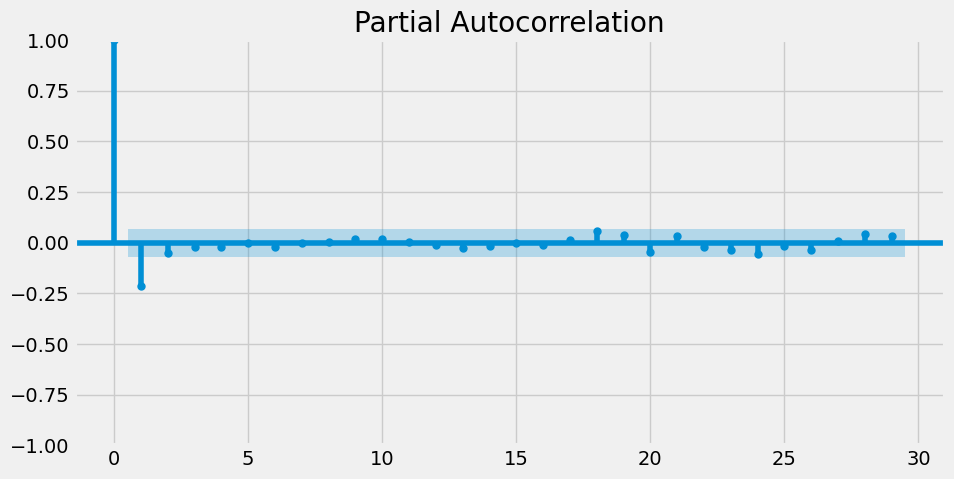

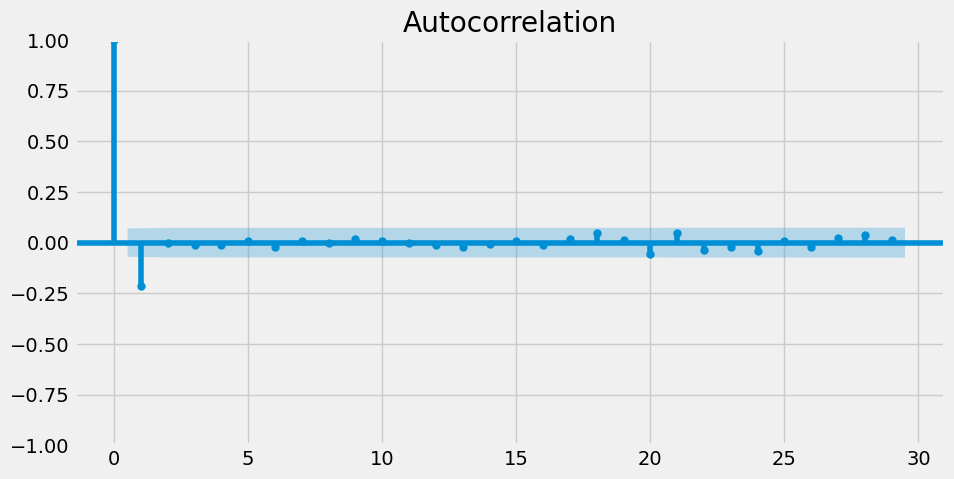

In [87]:
plot_pacf(best_model.resid);
plot_acf(best_model.resid);

In [89]:
model = ARIMA(train_data['Close'], order=(5, 2, 5))  
fitted = model.fit()  
print(fitted.summary())

D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  788
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -1511.968
Date:                Thu, 10 Nov 2022   AIC                           3045.936
Time:                        00:20:13   BIC                           3097.273
Sample:                             0   HQIC                          3065.674
                                - 788                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2916      0.031    -41.814      0.000      -1.352      -1.231
ar.L2         -0.8410      0.045    -18.870      0.000      -0.928      -0.754
ar.L3         -1.2037      0.042    -28.693      0.0

D:\BCP\ALGORTIMO\TALLER ECONOMIA PYTHON\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


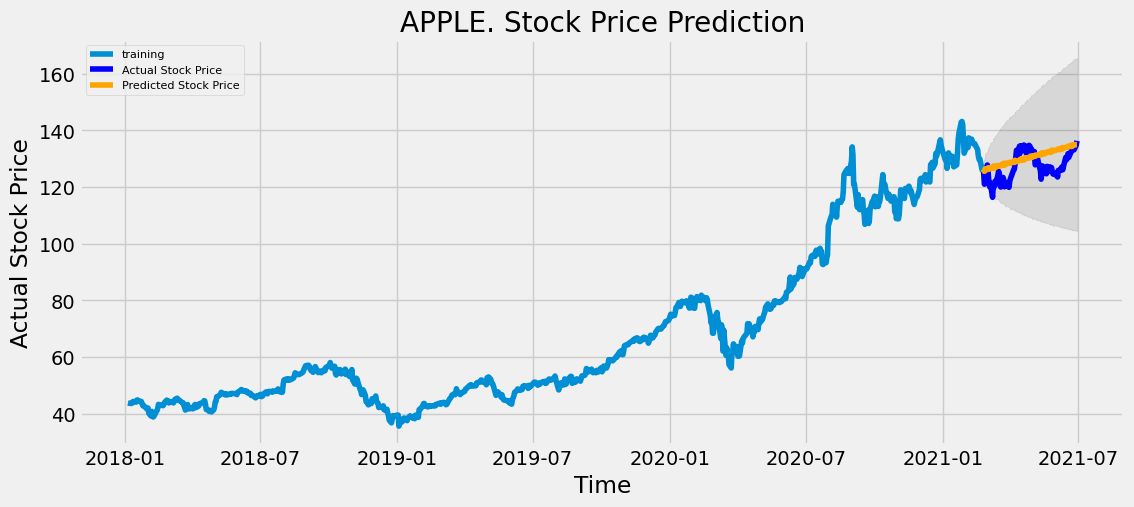

In [91]:
# Forecast
fc = fitted.get_forecast(88)  # 95% confidence
conf = fc.conf_int(alpha=0.05)
y_hat = fc.predicted_mean
#conf = fitted.conf_int(alpha=0.05)
fc_series = pd.Series(y_hat.values, index=test_data['Date'])
fc_series=fc_series.reset_index()
fc_series.columns=['Date','Close']
fc_series=fc_series.set_index(fc_series['Date'])
train_data=train_data.set_index(train_data['Date'])
test_data=test_data.set_index(test_data['Date'])
lower_series = conf['lower Close'].values
upper_series = conf['upper Close'].values
lower_series =  pd.Series(lower_series,index=test_data['Date'])
upper_series =  pd.Series(upper_series,index=test_data['Date'])
plt.figure(figsize=(12,5), dpi=100)
train_data
plt.plot(train_data['Close'], label='training')
plt.plot(test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series['Close'], color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('APPLE. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [95]:
#modelando

# Date range
start = '2018-01-01'
end = '2021-06-30'

# Tickers of assets
assets = ['ETH-USD']


# Downloading data
data= yf.download(assets, start = start, end = end)['Close']
data.head()
data=data.reset_index()

[*********************100%***********************]  1 of 1 completed


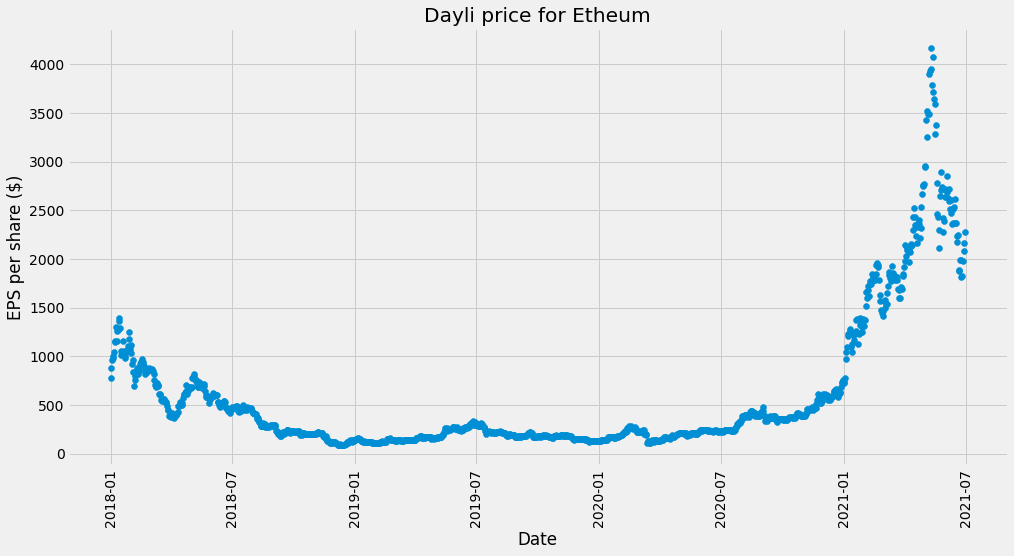

In [97]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(data['Date'], data['Close'])
plt.title('Dayli price for Etheum')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()